# Identificação do modelo linear das taxas

Os dados de entrada correspondem à resposta em frequência obtidos com o script `analise_resposta_em_freq.ipynb`.
Será analisada a taxa `p` variação do ângulo de rolagem.

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [145]:
# Carrega os dados de 'dados/freq_rad_p_rate.txt'
df_freq = pd.read_csv('dados/freq_rad_s_p_rate.txt')
freq_rad = df_freq.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/modulo_dB_p_rate.txt'
df_modulo = pd.read_csv('dados/modulo_dB_p_rate.txt')
modulo_dB = df_modulo.iloc[:, 0].astype(float)

# Carrega os dados de 'dados/fase_rad_p_rate.txt'
df_fase = pd.read_csv('dados/fase_rad_p_rate.txt')
fase_deg = df_fase.iloc[:, 0].astype(float)

# Modelo da dinâmica da taxa p
$$
\dfrac{P(s)}{U(s)}=\dfrac{e^{-\tau s}}{I_{xx}s}
$$

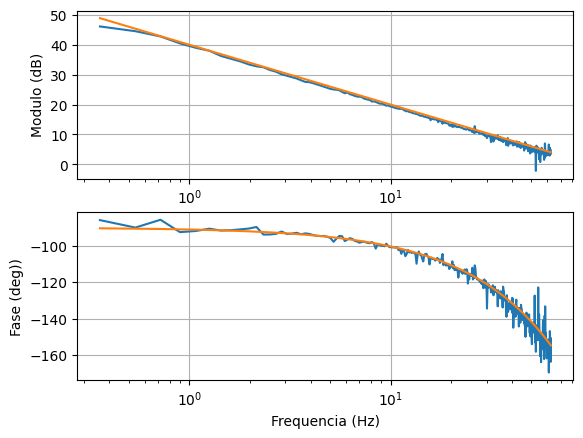

In [146]:
K = 100 # 1/Ixx
tau = 0.018
a = 0.4
def tf(w):
    s = complex(0,w)
    return K*np.exp(-tau*s) / (s)
# Calcula a resposta em frequência de tf
mod_tf_dB = np.zeros(len(freq_rad))
tf_fase = np.zeros(len(freq_rad))
for i in range(len(freq_rad)):
    mod_tf_dB[i] = 20*np.log10(abs(tf(freq_rad[i])))
    tf_fase[i] = np.angle(tf(freq_rad[i]))*180/np.pi
# grafico de Bode
plt.figure()
plt.subplot(2, 1, 1)
plt.semilogx(freq_rad, modulo_dB)
plt.semilogx(freq_rad, mod_tf_dB)
plt.grid()
plt.ylabel('Modulo (dB)')
plt.subplot(2, 1, 2)
plt.semilogx(freq_rad, fase_deg)
plt.semilogx(freq_rad, np.unwrap(tf_fase))
plt.grid()
plt.ylabel('Fase (deg))')
plt.xlabel('Frequencia (Hz)')
plt.show()

In [147]:
Ixx = 1/K
Ixx

0.01

In [148]:
tau

0.018

O modelo identificado é:
$$
\dfrac{P(s)}{U(s)}=\dfrac{1}{I_{xx}s}e^{-\tau s}
$$
com $I_{xx}=0.01$ e $\tau=0.018$.